<h1>130. Linear Regression: Hyper Parameter 조정</h1> 

- 대표적 Hyper-Parameter 인 Learning Rate 변화에 따른 model performance 의 변화를 시각화

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [2]:
class Data(Dataset):
    def __init__(self, train=True):
        # x 값을 -3에서 3까지 0.1 간격으로 생성하고, 이를 열 벡터로 변환합니다.
        self.x = torch.arange(-3, 3, 0.1).view(-1, 1)
        # 참 함수 f(x) = -3x + 1을 정의합니다.
        self.f = -3 * self.x + 1
        # 참 함수에 약간의 노이즈를 더하여 y 값을 생성합니다.
        self.y = self.f + 0.1 * torch.randn(self.x.size())
        # 데이터셋의 길이를 저장합니다.
        self.len = self.x.shape[0]
        
        # 훈련 세트일 경우에만 이상치를 추가합니다.
        if train:
            self.y[0] = 0  # 첫 번째 데이터 포인트를 이상치로 설정합니다.
            self.y[50:55] = 20  # 50번에서 54번까지의 데이터 포인트를 이상치로 설정합니다.
        else:
            pass  # 테스트 세트일 경우 아무것도 하지 않습니다.
        
    def __getitem__(self, idx):
        # 주어진 인덱스 idx에 해당하는 x와 y 값을 반환합니다.
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        # 데이터셋의 전체 길이를 반환합니다.
        return self.len

- data 를 생성했던 true function 을 line 으로 그리고 training points 를 적색으로 표시.   

- outlier 가 x=-3 과 x=2 부근에 있음

In [3]:
train_data = Data()  # with noise

val_data = Data(train=False)  # No noise

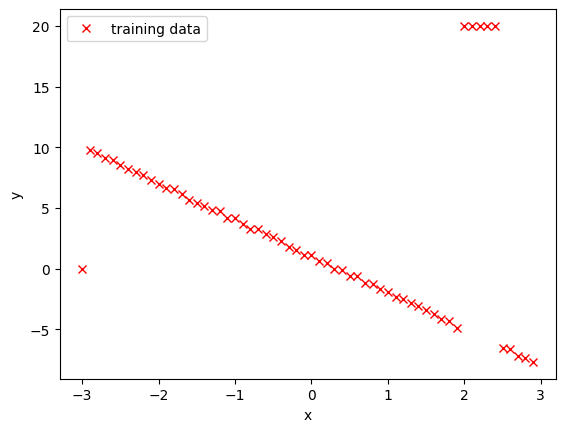

In [4]:
# Plot training points
plt.plot(train_data.x.numpy(), train_data.y.numpy(), 'xr', label="training data")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

<h2>Linear Regression Model,  Data Loader 및 Criterion Function 생성</h2>

In [5]:
class linear_regression(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        yhat = self.linear(x)
        return yhat

In [6]:
criterion = nn.MSELoss()
trainloader = DataLoader(dataset=train_data, batch_size=1)

<h2>서로 다른 learning rate 로 train 하고 model 저장</h2>

In [7]:
learning_rates = [0.0001, 0.001, 0.01, 0.1]

validation_error = torch.zeros(len(learning_rates))

MODELS = []

<h2>서로 다른 Learnng Rate 에 대해 별도 model 훈련</h2>

다양한 learning rate 를 시도하고, SGD 를 수행하고, 각 모델을 list 에 저장합니다.

In [10]:
ITER = 100  

# 주어진 학습률 목록을 반복하면서 학습을 진행합니다.
for i, lr in enumerate(learning_rates):
    # 새로운 선형 회귀 모델을 생성합니다.
    model = linear_regression(1, 1)
    # 주어진 학습률로 SGD 옵티마이저를 설정합니다.
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    # 주어진 에포크 수만큼 학습을 반복합니다.
    for epoch in range(ITER):
        # 학습 데이터를 로드하여 미니배치 학습을 진행합니다.
        for x, y in trainloader:
            yhat = model(x)            # 모델을 통해 예측값 yhat을 계산합니다.
            loss = criterion(yhat, y)  # 예측값 yhat과 실제값 y를 비교하여 손실(loss)을 계산합니다.
            optimizer.zero_grad()      # 옵티마이저의 그래디언트를 초기화합니다.
            loss.backward()            # 손실에 대한 그래디언트를 계산합니다.
            optimizer.step()           # 옵티마이저를 사용하여 모델의 가중치를 업데이트합니다.
            
    print("learning rate = ", lr)  # 현재 학습률을 출력합니다.
    
    # 검증 데이터(validation data)를 사용하여 모델의 성능을 평가합니다.
    Yhat = model(val_data.x)                # 검증 데이터를 사용하여 예측값 Yhat을 계산합니다.
    val_loss = criterion(Yhat, val_data.y)  # 예측값 Yhat과 실제 검증값을 비교하여 손실(val_loss)을 계산합니다.
    validation_error[i] = val_loss.item()   # 검증 손실 값을 validation_error 배열에 저장합니다.
    print("validation loss =", val_loss.item())                  # 검증 손실 값을 출력합니다.
    print()
    
    MODELS.append(model)  # 학습된 모델을 MODELS 리스트에 추가합니다.

learning rate =  0.0001
validation loss = 11.25821304321289

learning rate =  0.001
validation loss = 13.683453559875488

learning rate =  0.01
validation loss = 10.55325698852539

learning rate =  0.1
validation loss = 6.714859485626221



In [11]:
print(validation_error)

tensor([11.2582, 13.6835, 10.5533,  6.7149])


<h2 id="Result">View the Results</h2>  

각 model 에 대해 validation data 로 prediction 을 생성하여 true data 와 비교. 각 learning rate 별로 10 epoch 동안 얼마나 train 되었는지 비교

- Tensor가 기록을 추적하는 것을 중단하게 하려면, .detach() 를 호출하여 연산 기록으로부터 분리(detach)하여 이후 연산들이 추적되는 것을 방지할 수 있다.|

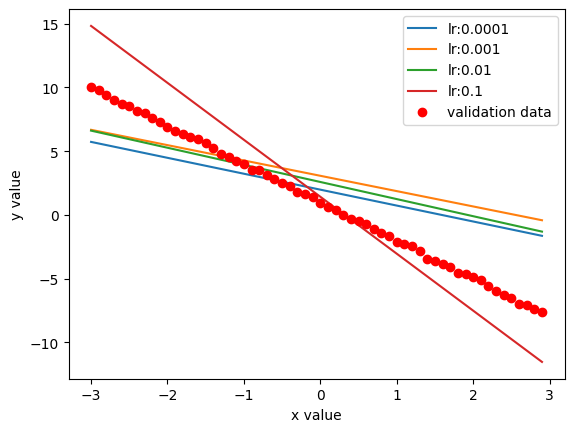

In [12]:
# 저장된 모델들과 학습률을 사용하여 예측값을 계산하고 플롯을 그립니다.
for model, learning_rate in zip(MODELS, learning_rates):
    yhat = model(val_data.x)  # 검증 데이터의 입력값을 사용하여 예측값 yhat을 계산합니다.
    # 예측값 yhat을 numpy 배열로 변환하여 플롯합니다. 라벨에는 학습률을 표시합니다.
    plt.plot(val_data.x.numpy(), yhat.detach().numpy(), label='lr:' + str(learning_rate))

# 검증 데이터의 실제값을 빨간색 원('ro')으로 플롯합니다.
plt.plot(val_data.x.numpy(), val_data.y.numpy(), 'ro', label="validation data")
plt.xlabel('x value')  
plt.ylabel('y value') 
plt.legend()
plt.show()  